In [1]:
import xarray
import numpy
import pandas

Results of running `eva_build_aod_file`, as described in the PMIP forcing documentation

In [2]:
aod_pmip = xarray.open_dataset('eva_evolv2k_pmip4_v2.1/eva_aod_T63_sw_-500_1900.nc')

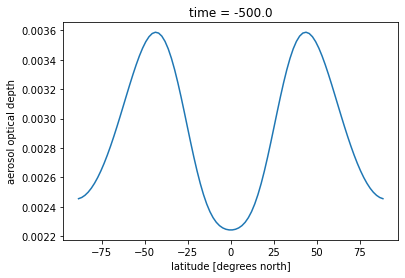

In [3]:
aod_pmip.aod550[0,:].plot()

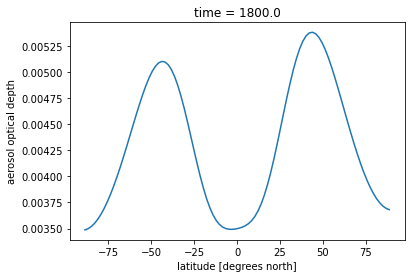

In [4]:
aod_pmip.aod550.sel(time=1800).plot()

AOD is the integral of extinction @ 550nm over height, which we can verify using the spectral output file

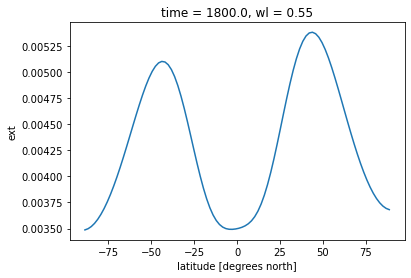

In [5]:
xarray.open_dataset('eva_evolv2k_pmip4_v2.1/eva_forcing_echam_T63_sw_1800.nc').ext.sel(wl=0.55).sum('z')[0,:].plot()

Mean AOD over time

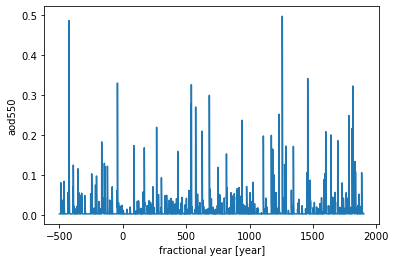

In [6]:
aod_pmip.aod550.mean('lat').plot()

The ESM paper says that piControl ran with an AOD of 0.01338, while the mean AOD of the prescribed CMIP6 forcings is 0.01067. The ACCESS-ESM forcing was increased so that the mean AOD remained constant through the whole simulation, with the values used by the model increased by 0.00271 over prescribed values

In [7]:
aod_pmip.aod550.mean(['lat','time'])

<xarray.DataArray 'aod550' ()>
array(0.01255035, dtype=float32)

ESM uses the mean AOD over three areas - 90N-30N, 30N-0N, 0S-30S, 30S-90S

In [8]:
aod_esm = aod_pmip.aod550.groupby_bins('lat',[-90,-30,0,30,90]).mean()
aod_esm

<xarray.DataArray 'aod550' (time: 28812, lat_bins: 4)>
array([[0.00308595, 0.00255146, 0.00255146, 0.00308595],
       [0.00303828, 0.00259169, 0.00255836, 0.00296814],
       [0.0030066 , 0.00259749, 0.00255635, 0.00292002],
       ...,
       [0.00301171, 0.00252517, 0.00258799, 0.00314391],
       [0.00303947, 0.00253522, 0.00256994, 0.00311254],
       [0.003077  , 0.00255086, 0.00254805, 0.00307109]], dtype=float32)
Coordinates:
  * lat_bins  (lat_bins) object (-90, -30] (-30, 0] (0, 30] (30, 90]
  * time      (time) float32 -500.0 -499.91666 ... 1900.8334 1900.9166

This data is read into the model variable `SCVARY`, from a space separated values file with columns YEAR, MONTH, AOD 90N30N, AOD 30N0N, AOD 0S30S, AOD 30S90S

In [9]:
year = numpy.floor(aod_esm.time)
month = numpy.round((aod_esm.time - year)*12)+1

aod_esm_df = pandas.DataFrame({'year': year, 'month': month, '90N30N': aod_esm[:,3], '30N00N': aod_esm[:,2], '00S30S': aod_esm[:,1], '30S90S': aod_esm[:,0]})

aod_esm_df

,year,month,90N30N,30N00N,00S30S,30S90S
0,-500.0,1.0,0.003086,0.002551,0.002551,0.003086
1,-500.0,2.0,0.002968,0.002558,0.002592,0.003038
2,-500.0,3.0,0.002920,0.002556,0.002597,0.003007
3,-500.0,4.0,0.002910,0.002549,0.002584,0.002983
4,-500.0,5.0,0.002921,0.002542,0.002561,0.002962
...,...,...,...,...,...,...
28807,1900.0,8.0,0.003145,0.002587,0.002521,0.003006
28808,1900.0,9.0,0.003156,0.002595,0.002520,0.003000
28809,1900.0,10.0,0.003144,0.002588,0.002525,0.003012
28810,1900.0,11.0,0.003113,0.002570,0.002535,0.003039


In [10]:
aod_esm_df.to_csv('VOLC_PMIP', index=False, header=False, sep=' ')

Code modification required to change the AOD file dates in:

```
./umbase_hg3/src/atmosphere/short_wave_radiation/glue_rad-rad_ctl3c.F90
./umbase_hg3/src/control/top_level/glue_rad-rad_ctl2.F90
./umbase_hg3/src/control/top_level/volcts_Mod.F90
./umbase_hg3/src/control/top_level/setcona.F90
```